<a href="https://colab.research.google.com/github/joanby/trading-algoritmico-a-z-con-python/blob/main/ES_TA_Cap%C3%ADtulo_06_Scalping_usando_la_estrategia_de_price_action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px">
<img alt="Colaboratory logo" height="45px" src="https://static-881c.kxcdn.com/wp-content/uploads/2016/03/frogamesLogoFull4.png" align="left" hspace="10px" vspace="0px"></p>

# Scalping Price Action


<br>

* Scalping: operación basada en negociaciones a corto plazo
* RSI: el indicador que mide los niveles de sobrecompra y sobreventa


💰 Únete a la comunidad de [Discord](https://discord.gg/wXjNPAc5BH)

📚 Puedes leer nuestro libro en [Amazon](https://www.amazon.com/gp/product/B09HG18CYL)

🖥️ El canal de [YouTube de Quantreo's](https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw) (en inglés) y el de [Frogames](https://www.youtube.com/channel/UCMUxXNYrVCv6-bQakhomvBg) en español

In [1]:
!pip install yfinance
!pip install mpl_finance
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 17.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in index

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import ta
import warnings
warnings.filterwarnings("ignore")

In [3]:
# El código aquí te permitirá cambiar los gráficos a modo oscuro para aquellos que optéis por programar en modo oscuro
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rcParams['figure.figsize'] = [20, 8]

# Importar los datos

In [4]:
# Importar los precios de las acciones de Yahoo Finanzas
df = yf.download("EURUSD=X", start="2010-01-01")

# Creamos una columna de fecha para dibujar el Candlestick más tarde (no es obligatorio si no quieres representarlo)
df['Date'] = pd.to_datetime(df.index)
df['Date'] = df['Date'].apply(mpl_dates.date2num)

# Cambiar el nombre de las columnas
df.columns = ["open", "high", "low", "close", "adj close", "volume", "date"]
df.index.name = "time"
df

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj close,volume,date
time,,,,,,,
2010-01-01,1.432706,1.440196,1.432706,1.438994,1.438994,0,733773.0
2010-01-04,1.431004,1.445191,1.426208,1.442398,1.442398,0,733776.0
2010-01-05,1.442710,1.448310,1.435194,1.436596,1.436596,0,733777.0
2010-01-06,1.436596,1.443460,1.429123,1.440403,1.440403,0,733778.0
2010-01-07,1.440300,1.444481,1.430206,1.431803,1.431803,0,733779.0
...,...,...,...,...,...,...,...
2022-06-16,1.045620,1.053031,1.038260,1.045620,1.045620,0,738322.0
2022-06-17,1.054685,1.055175,1.044561,1.054685,1.054685,0,738323.0
2022-06-20,1.049142,1.054519,1.048636,1.049142,1.049142,0,738326.0


# Creación del Soporte y la Resistencia

In [5]:
# Creamos Columnas Vacías 
df["support"] = np.nan
df["resistance"] = np.nan

# Después de 5 descensos consecutivos del mínimo, anotamos este precio como el soporte
df.loc[(df["low"].shift(5) > df["low"].shift(4))&
       (df["low"].shift(4) > df["low"].shift(3))&
       (df["low"].shift(3) > df["low"].shift(2))&
       (df["low"].shift(2) > df["low"].shift(1))&
       (df["low"].shift(1) > df["low"].shift(0)), "support"] = df["low"]


# Después de 5 subidas consecutivas del máximo, observamos este precio como la resistencia
df.loc[(df["high"].shift(5) < df["high"].shift(4)) &
(df["high"].shift(4) < df["high"].shift(3)) &
(df["high"].shift(3) < df["high"].shift(2)) &
(df["high"].shift(2) < df["high"].shift(1)) &
(df["high"].shift(1) < df["high"].shift(0)), "resistance"] = df["high"]

In [6]:
df

,open,high,low,close,adj close,volume,date,support,resistance
time,,,,,,,,,
2010-01-01,1.432706,1.440196,1.432706,1.438994,1.438994,0,733773.0,NaN,NaN
2010-01-04,1.431004,1.445191,1.426208,1.442398,1.442398,0,733776.0,NaN,NaN
2010-01-05,1.442710,1.448310,1.435194,1.436596,1.436596,0,733777.0,NaN,NaN
2010-01-06,1.436596,1.443460,1.429123,1.440403,1.440403,0,733778.0,NaN,NaN
2010-01-07,1.440300,1.444481,1.430206,1.431803,1.431803,0,733779.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-06-16,1.045620,1.053031,1.038260,1.045620,1.045620,0,738322.0,1.03826,NaN
2022-06-17,1.054685,1.055175,1.044561,1.054685,1.054685,0,738323.0,NaN,NaN
2022-06-20,1.049142,1.054519,1.048636,1.049142,1.049142,0,738326.0,NaN,NaN


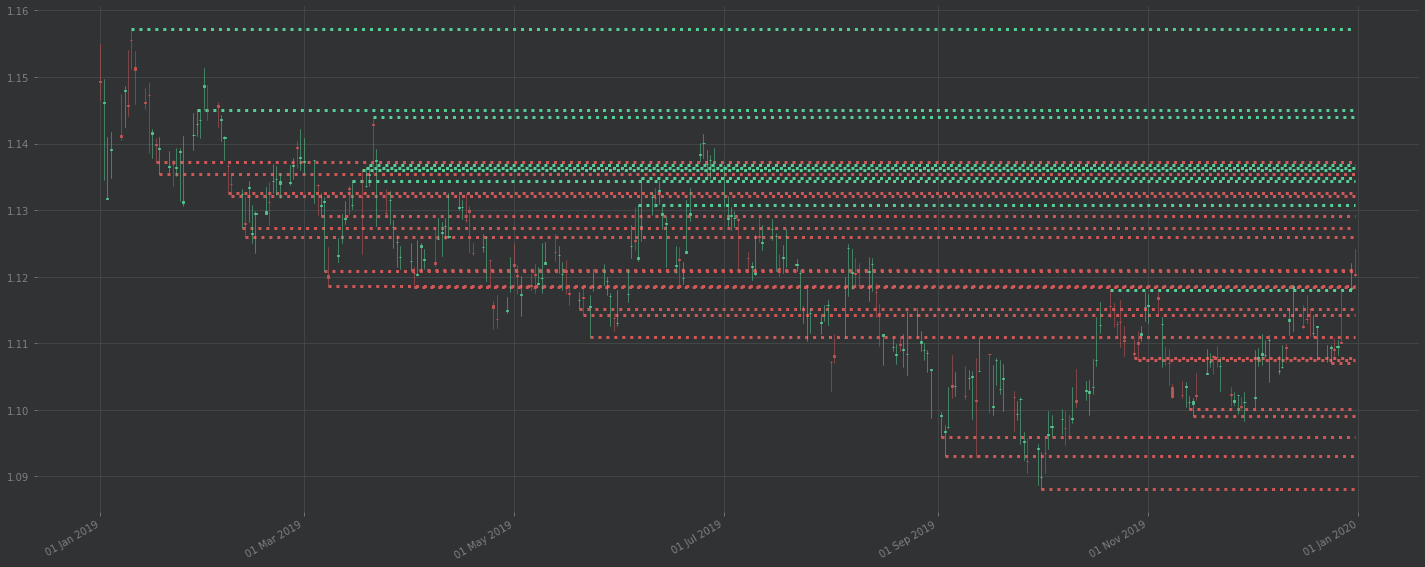

In [7]:
df_bis = df.loc["2019"]

# Inicializar el gráfico
fig, ax = plt.subplots()

# Dibujar el candlestick
candlestick_ohlc(ax,df_bis[["date", "open", "high", "low", "close"]].values,width=0.6, \
                  colorup='#57CE95', colordown='#CE5757', alpha=0.8)

# Poner la fecha como eje x
date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()

# Representar líneas de resistencia
for resistance, date in zip(df_bis["resistance"].dropna(), df_bis["resistance"].dropna().index):
  plt.hlines(resistance, xmin=date, xmax=df_bis.index[-1], colors='#57CE95', linestyles=":", linewidth=3)

# Representar líneas de soporte
for support, date in zip(df_bis["support"].dropna(), df_bis["support"].dropna().index):
  plt.hlines(support, xmin=date, xmax=df_bis.index[-1], colors='#CE5757', linestyles=":", linewidth=3)

# Representar la figura
fig.show()

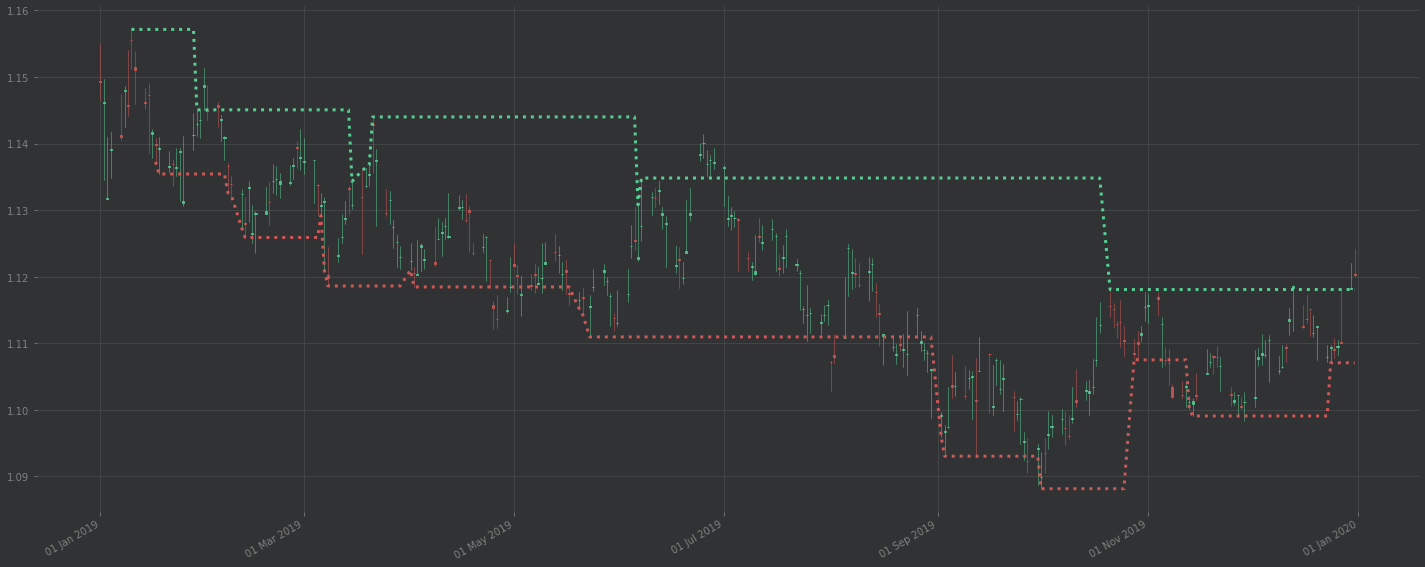

In [8]:
df = df.loc["2019"]

# Inicializar el gráfico
fig, ax = plt.subplots()

# Representar el candlestick
candlestick_ohlc(ax,df[["date", "open", "high", "low", "close"]].values,width=0.6, \
                  colorup='#57CE95', colordown='#CE5757', alpha=0.8)

# Poner la fecha como eje x
date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()

# Representar líneas de resistencia
plt.plot(df["support"].fillna(method="ffill"),color='#CE5757', linestyle=":", linewidth=3)


# Representar líneas de soporte
plt.plot(df["resistance"].fillna(method="ffill"),color='#57CE95', linestyle=":", linewidth=3)

# Mostrar la figura
fig.show()

# Estrategia de Soporte y Estrategia

In [9]:
# Crear la señal
df["signal"] = 0

# Suavizar el soporte y la resistencia para crear la estrategia
df["smooth resistance"] = df["resistance"].fillna(method="ffill")
df["smooth support"] = df["support"].fillna(method="ffill")

# Crear condiciones de compra
condition_1_buy = (df["close"].shift(1) < df["smooth resistance"].shift(1)) &\
                   (df["smooth resistance"]*(1+0.0/100)<df["close"])

# Crear condiciones de venta
condition_1_sell = (df["close"].shift(1) > df["smooth support"].shift(1)) &\
                   (df["smooth support"]*(1-0.0/100)>df["close"])


# Colocar la señal
df.loc[condition_1_buy, "signal"] = 1
df.loc[condition_1_sell, "signal"] = -1

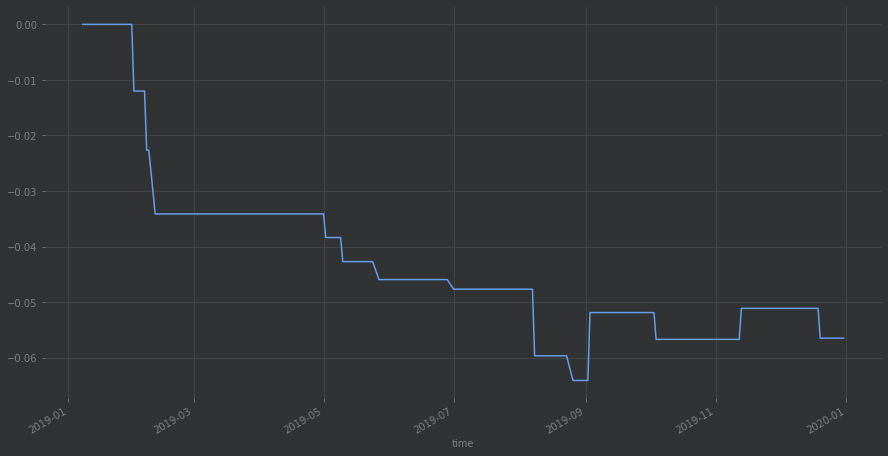

In [10]:
duration = 5

# Compute the percentage of variation of the asset
df["pct"] = df["close"].pct_change(1)

# Compute the return of the strategy
df["return"] = np.array([df["pct"].shift(i) for i in range(duration)]).sum(axis=0) * (df["signal"].shift(duration))


df["return"].cumsum().plot(figsize=(15,8))

# Soporte y Resistencia + SMA

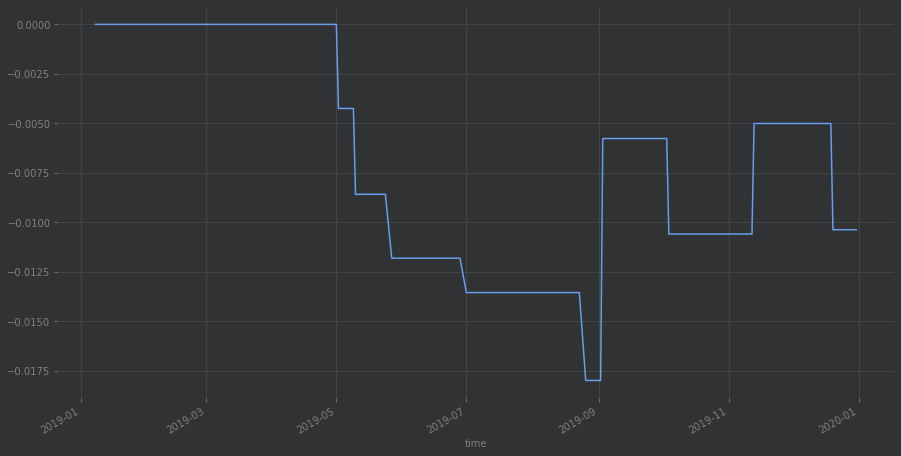

In [11]:
# Crear media móvil simple de 30 días
df["SMA fast"] = df["close"].rolling(30).mean()

# Crear media móvil simple de 60 días
df["SMA slow"] = df["close"].rolling(60).mean()

condition_2_buy = df["SMA fast"] > df["SMA slow"]
condition_2_sell = df["SMA fast"] < df["SMA slow"]



df["signal"] = 0

df.loc[condition_1_buy & condition_2_buy, "signal"] = 1
df.loc[condition_1_sell & condition_2_sell, "signal"] = -1


# Calcular el porcentaje de variación del activo
df["pct"] = df["close"].pct_change(1)

# Calcular la rentabilidad de la estrategia
df["return"] = np.array([df["pct"].shift(i) for i in range(duration)]).sum(axis=0) * (df["signal"].shift(duration))

df["return"].cumsum().plot(figsize=(15,8))

# Soporte y Resistencia + SMA + RSI

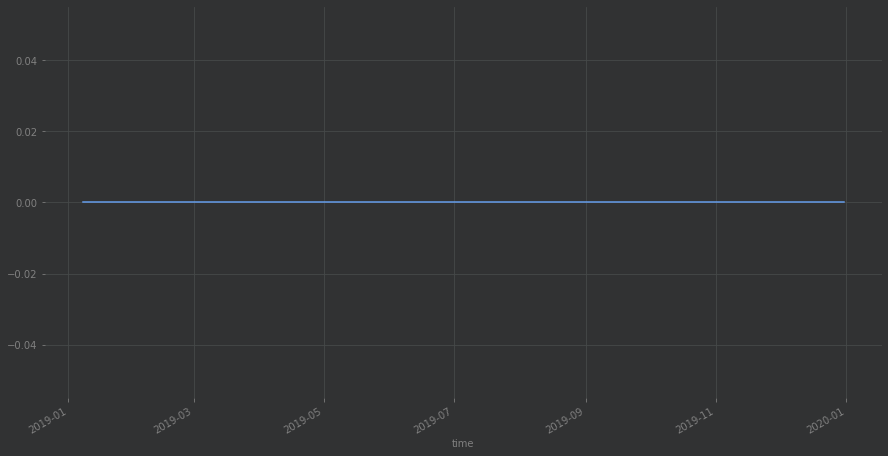

In [12]:
df["rsi"] = ta.momentum.RSIIndicator(df["close"], window=10).rsi()

# RSI de ayer
df["rsi yersteday"] = df["rsi"].shift(1)

df["signal"] = 0
condition_3_buy = df["rsi"] < df["rsi yersteday"]

condition_3_sell = df["rsi"] > df["rsi yersteday"]



df.loc[condition_1_buy & condition_2_buy & condition_3_buy, "signal"] = 1
df.loc[condition_1_sell & condition_2_sell & condition_3_sell, "signal"] = -1


# Calcular el porcentaje de variación del activo
df["pct"] = df["close"].pct_change(1)

# Calcular la rentabilidad de la estrategia
df["return"] = np.array([df["pct"].shift(i) for i in range(duration)]).sum(axis=0) * (df["signal"].shift(duration))

df["return"].cumsum().plot(figsize=(15,8))

# Automatizar el proceso

In [13]:
def support_resistance(df, duration=5,spread=0):
  """EL DATAFRAME NECESITA TENER los siguientes nombres de columna: alta, baja, cierre"""

  # Support and resistance building
  df["support"] = np.nan
  df["resistance"] = np.nan

  df.loc[(df["low"].shift(5) > df["low"].shift(4)) &
        (df["low"].shift(4) > df["low"].shift(3)) &
        (df["low"].shift(3) > df["low"].shift(2)) &
        (df["low"].shift(2) > df["low"].shift(1)) &
        (df["low"].shift(1) > df["low"].shift(0)), "support"] = df["low"]


  df.loc[(df["high"].shift(5) < df["high"].shift(4)) &
  (df["high"].shift(4) < df["high"].shift(3)) &
  (df["high"].shift(3) < df["high"].shift(2)) &
  (df["high"].shift(2) < df["high"].shift(1)) &
  (df["high"].shift(1) < df["high"].shift(0)), "resistance"] = df["high"]


  # Create Simple moving average 30 days
  df["SMA fast"] = df["close"].rolling(30).mean()

  # Create Simple moving average 60 days
  df["SMA slow"] = df["close"].rolling(60).mean()

  df["rsi"] = ta.momentum.RSIIndicator(df["close"], window=10).rsi()

  # RSI yersteday
  df["rsi yersteday"] = df["rsi"].shift(1)

  # Create the signal
  df["signal"] = 0

  df["smooth resistance"] = df["resistance"].fillna(method="ffill")
  df["smooth support"] = df["support"].fillna(method="ffill")


  condition_1_buy = (df["close"].shift(1) < df["smooth resistance"].shift(1)) & \
                    (df["smooth resistance"]*(1+0.5/100) < df["close"])
  condition_2_buy = df["SMA fast"] > df["SMA slow"]

  condition_3_buy = df["rsi"] < df["rsi yersteday"]

  condition_1_sell = (df["close"].shift(1) > df["smooth support"].shift(1)) & \
                    (df["smooth support"]*(1+0.5/100) > df["close"])
  condition_2_sell = df["SMA fast"] < df["SMA slow"]

  condition_3_sell = df["rsi"] > df["rsi yersteday"]



  df.loc[condition_1_buy & condition_2_buy & condition_3_buy, "signal"] = 1
  df.loc[condition_1_sell & condition_2_sell & condition_3_sell, "signal"] = -1


  # Calculamos las ganancias
  df["pct"] = df["close"].pct_change(1)

  df["return"] = np.array([df["pct"].shift(i) for i in range(duration)]).sum(axis=0) * (df["signal"].shift(duration))
  df.loc[df["return"]==-1, "return"] = df["return"]-spread
  df.loc[df["return"]==1, "return"] = df["return"]-spread


  return df["return"]

In [20]:
# Función de Pre Procesado

def preprocessing_min(name):

  # Import the data
  df = pd.read_csv(name, delimiter="\t", index_col=["<DATE>","<TIME>"] , parse_dates=True).dropna()

  # Delete the two last columns
  df = df.iloc[:,:-2]

  # Rename
  df.columns = ["open", "high", "low", "close", "volume"]
  #df.index.name = "time"
  return df

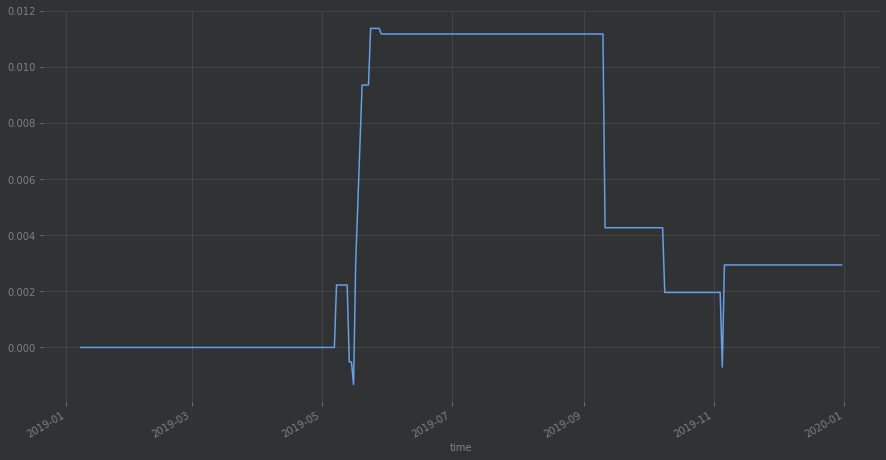

In [21]:
dfc = preprocessing_min("EURUSD_M1.csv")
dfc


support_resistance(df).cumsum().plot(figsize=(15,8))

In [22]:
dfc

open     high      low    close  volume
<DATE>     <TIME>                                                         
2021-11-17 2022-06-22 16:17:00  1.13006  1.13033  1.13006  1.13023     103
           2022-06-22 16:18:00  1.13023  1.13029  1.13010  1.13028      53
           2022-06-22 16:19:00  1.13028  1.13045  1.13027  1.13038      72
           2022-06-22 16:20:00  1.13037  1.13045  1.13034  1.13039     100
           2022-06-22 16:21:00  1.13039  1.13044  1.13032  1.13038      45
...                                 ...      ...      ...      ...     ...
2022-02-23 2022-06-22 08:01:00  1.13267  1.13280  1.13265  1.13275      20
           2022-06-22 08:02:00  1.13275  1.13275  1.13271  1.13272      12
           2022-06-22 08:03:00  1.13272  1.13272  1.13267  1.13268      10
           2022-06-22 08:04:00  1.13269  1.13270  1.13267  1.13268      13
           2022-06-22 08:05:00  1.13268  1.13275  1.13268  1.13275      15

[99939 rows x 5 columns]

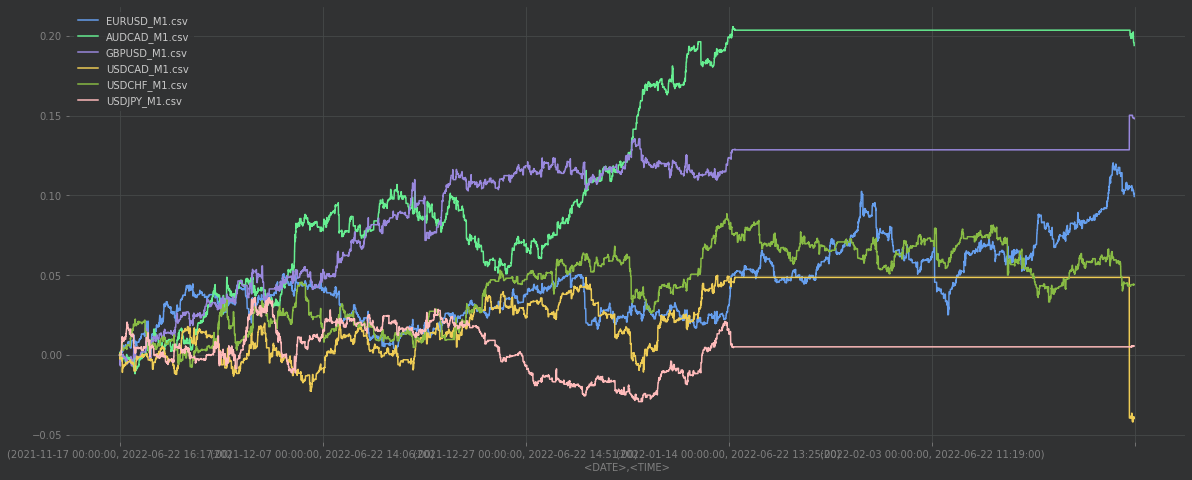

In [23]:
# Lista de assets
listnames = ["EURUSD_M1.csv", "AUDCAD_M1.csv", "GBPUSD_M1.csv", "USDCAD_M1.csv", "USDCHF_M1.csv", "USDJPY_M1.csv"]
returns = pd.DataFrame()

# Calcular la rentabilidad de cada estrategia
for name in listnames:
  dfc = preprocessing_min(name)
  returns[name] = support_resistance(dfc, duration=10, spread=0.0001)

# Representar los resultados
returns.fillna(value=0).cumsum().plot()

# Diversificar la cartera


In [25]:
returns["portfolio"] = returns.sum(axis=1)/returns.shape[1]

In [26]:
def drawdown_function(serie):

  # Calculamos la suma de los rendimientos
  cum = serie.dropna().cumsum() + 1

  # Calculamos el máximo de la suma en el período (acumulamos el máximo) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # Calculamos el drawdown
  drawdown = cum/running_max - 1
  return drawdown

In [27]:
# Dataframe vacío
values = pd.DataFrame(index=["RETURN", "DRAWDOWN", "RETURN DRAWDOWN RATIO"])

# Calculamos retorno/drawdown
for col in returns.columns:
  ret = (returns[col].dropna().cumsum().iloc[-1])
  dd = -np.min(drawdown_function(returns[col].dropna()))
  ret_dd = ret/dd
  
  values[col] = ret,dd,ret_dd

values.transpose().sort_values(by="RETURN DRAWDOWN RATIO", ascending=False)

,RETURN,DRAWDOWN,RETURN DRAWDOWN RATIO
GBPUSD_M1.csv,0.148140,0.034325,4.315870
portfolio,0.075286,0.017643,4.267281
AUDCAD_M1.csv,0.194051,0.050614,3.833980
EURUSD_M1.csv,0.099394,0.070223,1.415415
USDCHF_M1.csv,0.044210,0.050860,0.869243
USDJPY_M1.csv,0.005651,0.062849,0.089915
USDCAD_M1.csv,-0.039733,0.087582,-0.453669
